In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from stable_baselines3 import SAC

from gpu_acc_se import compute_se_np
from multi_input_env.env import CFmMIMOEnv as CFmMIMOEnv_Multi
from power_optimization import power_opt_maxmin, power_opt_prod_sinr, power_opt_sum_rate
from simulation_para import L, K, tau_p, min_power, max_power, initial_power, square_length, decorr, sigma_sf, \
    noise_variance_dbm, delta
from single_input_env.env import CFmMIMOEnv as CFmMIMOEnv_Single

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
AP_locations = torch.rand(L, dtype=torch.complex64, device=device) * square_length
UE_initial_locations = torch.rand(K, dtype=torch.complex64, device=device) * square_length

In [3]:
SI_ENV = CFmMIMOEnv_Single(L=L, K=K, tau_p=tau_p, initial_power=initial_power, min_power=min_power, max_power=max_power,
                           APs_positions=AP_locations, UEs_positions=UE_initial_locations, square_length=square_length,
                           decorr=decorr, sigma_sf=sigma_sf, noise_variance_dbm=noise_variance_dbm, delta=delta)

MI_EV = CFmMIMOEnv_Multi(L=L, K=K, tau_p=tau_p, initial_power=initial_power, min_power=min_power, max_power=max_power,
                         APs_positions=AP_locations, UEs_positions=UE_initial_locations, square_length=square_length,
                         decorr=decorr, sigma_sf=sigma_sf, noise_variance_dbm=noise_variance_dbm, delta=delta)


In [22]:
num_of_setups = 1000
prelog_factor = 1

In [23]:
SAC_CFmMIMO_SGD_SI = SAC.load("SAC_CFmMIMO_SGD")
SAC_CFmMIMO_Adam_SI = SAC.load("SAC_CFmMIMO_Adam")
SAC_CFmMIMO_Adam_MI = SAC.load("SAC_CFmMIMO_Adam(2x256)")

In [24]:
cf_signal = np.zeros((K, num_of_setups))
cf_interference = np.zeros((K, K, num_of_setups))
cf_pred_power = np.zeros((K, num_of_setups))

cf_SE_SGD = np.zeros((K, num_of_setups))
cf_SE_Adam = np.zeros((K, num_of_setups))
cf_SE_Adam_256 = np.zeros((K, num_of_setups))

SE_maxmin_cell = np.zeros((K, num_of_setups))
SE_maxprod_cell = np.zeros((K, num_of_setups))
SE_sumrate_cell = np.zeros((K, num_of_setups))

over_all_time = time.time()
for n in range(num_of_setups):
    
    obs_SI_ENV, sig_int = SI_ENV.reset()

    init_signal = sig_int['init_signal']
    init_interference = sig_int['init_interference']
    
    action, _ = SAC_CFmMIMO_SGD_SI.predict(obs_SI_ENV, deterministic=True)
    _, _, _, _, info = SI_ENV.step(action)
    cf_SE_SGD[:, n] = compute_se_np(init_signal, init_interference, info['predicted_power'], prelog_factor)

    action, _ = SAC_CFmMIMO_Adam_SI.predict(obs_SI_ENV, deterministic=True)
    _, _, _, _, info = SI_ENV.step(action)
    cf_SE_Adam[:, n] = compute_se_np(init_signal, init_interference, info['predicted_power'], prelog_factor)
    
    SE_maxmin, _ = power_opt_maxmin(init_signal, init_interference, max_power, 1, return_SE=True)
    SE_maxmin_cell[:, n] = SE_maxmin

    SE_maxprod, _ = power_opt_prod_sinr(init_signal, init_interference, max_power, 1, return_SE=True)
    SE_maxprod_cell[:, n] = SE_maxprod

    SE_sumrate, _ = power_opt_sum_rate(init_signal, init_interference, max_power, 1, return_SE=True)
    SE_sumrate_cell[:, n] = SE_sumrate
    
    obs_MI_EV, _ = MI_EV.reset()

    init_signal = sig_int['init_signal']
    init_interference = sig_int['init_interference']
    
    action, _ = SAC_CFmMIMO_Adam_MI.predict(obs_MI_EV, deterministic=True)
    _, _, _, _, info = MI_EV.step(action)
    cf_SE_Adam_256[:, n] = compute_se_np(init_signal, init_interference, info['predicted_power'], prelog_factor)

print('Total inference: ', time.time() - over_all_time)

Total inference:  2692.5910279750824


In [25]:
cf_SE_SGD_flatter = cf_SE_SGD.flatten()
sorted_cf_SE_SGD = np.sort(cf_SE_SGD_flatter)
cdf_SE_SGD_pred = np.linspace(0, 1, len(sorted_cf_SE_SGD))

cf_SE_Adam_flatter = cf_SE_Adam.flatten()
sorted_cf_SE_Adam = np.sort(cf_SE_Adam_flatter)
cdf_SE_Adam_pred = np.linspace(0, 1, len(sorted_cf_SE_Adam))

cf_SE_Adam_256_flatter = cf_SE_Adam_256.flatten()
sorted_cf_SE_Adam_256 = np.sort(cf_SE_Adam_256_flatter)
cdf_SE_Adam_256_pred = np.linspace(0, 1, len(sorted_cf_SE_Adam_256))

In [26]:
SE_maxmin_flatten = SE_maxmin_cell.flatten()
SE_maxprod_flatten = SE_maxprod_cell.flatten()
SE_sumrate_flatten = SE_sumrate_cell.flatten()

sorted_SE_maxmin = np.sort(SE_maxmin_flatten)
sorted_SE_maxprod = np.sort(SE_maxprod_flatten)
sorted_SE_sumrate = np.sort(SE_sumrate_flatten)

cdf_SE_maxmin = np.linspace(0, 1, len(sorted_SE_maxmin))
cdf_SE_maxprod = np.linspace(0, 1, len(sorted_SE_maxprod))
cdf_SE_sumrate = np.linspace(0, 1, len(sorted_SE_sumrate))

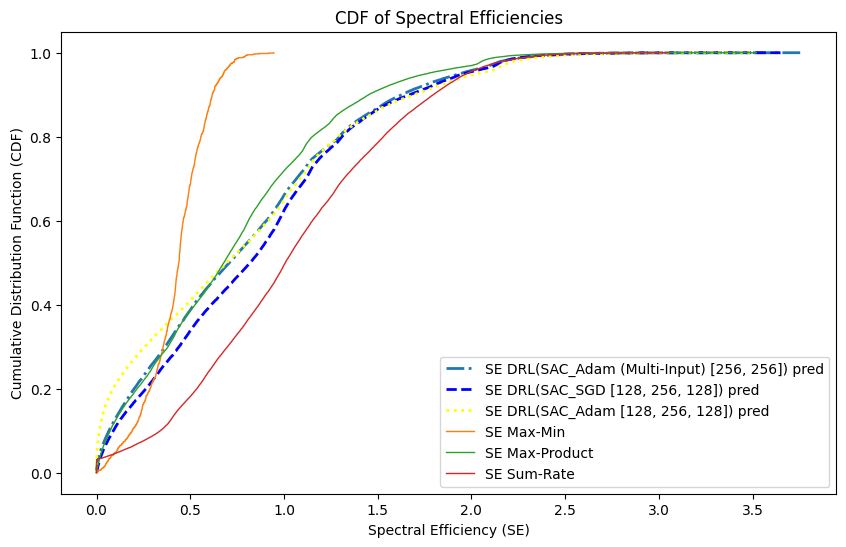

In [28]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sorted_cf_SE_Adam_256, cdf_SE_Adam_256_pred, label='SE DRL(SAC_Adam (Multi-Input) [256, 256]) pred', linewidth=2, linestyle='-.')
plt.plot(sorted_cf_SE_SGD, cdf_SE_SGD_pred, label='SE DRL(SAC_SGD [128, 256, 128]) pred', linewidth=2, linestyle='--', color='blue')
plt.plot(sorted_cf_SE_Adam, cdf_SE_Adam_pred, label='SE DRL(SAC_Adam [128, 256, 128]) pred', linewidth=2, linestyle=':', color='yellow')
plt.plot(sorted_SE_maxmin, cdf_SE_maxmin, label='SE Max-Min', linewidth=1)
plt.plot(sorted_SE_maxprod, cdf_SE_maxprod, label='SE Max-Product', linewidth=1)
plt.plot(sorted_SE_sumrate, cdf_SE_sumrate, label='SE Sum-Rate', linewidth=1)

plt.xlabel('Spectral Efficiency (SE)')
plt.ylabel('Cumulative Distribution Function (CDF)')
plt.title('CDF of Spectral Efficiencies')
plt.legend()